In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

# Set pandas to display floats in normal decimal format
pd.set_option('display.float_format', '{:.3f}'.format)

# Set visual style
sns.set_style("dark")
plt.rcParams["axes.facecolor"] = "#FDFFE2"
plt.rcParams["figure.facecolor"] = "#FDFFE2"
plt.rcParams["axes.edgecolor"] = "#FDFFE2"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 14

# Load dataset
fires_df = pd.read_csv('fires.csv')

# Drop the index column
fires_df = fires_df.drop(columns=["Unnamed: 0"])

def quick_profile(df: pd.DataFrame) -> None:
    """
    Generate a quick profile of a pandas DataFrame.
    
    Args:
        df (pd.DataFrame): Input dataset.
    """
    print("DATASET PROFILE")
    print("=" * 60)

    # --- Basic info ---
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # --- Column types ---
    print("\nColumn Types:")
    print(df.dtypes.value_counts().to_string())

    # --- Numeric summary ---
    numeric_cols = df.select_dtypes(include="number").columns
    if numeric_cols.any():
        print("\nNumeric Columns Summary:")
        display(df[numeric_cols].describe().T.round(2))  # nicer table in Jupyter

    # --- Categorical summary ---
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    if categorical_cols.any():
        print("\nCategorical Columns:")
        for col in categorical_cols:
            unique_count = df[col].nunique(dropna=True)
            print(f"  {col}: {unique_count} unique values")

            value_counts = df[col].value_counts(dropna=False)
            if unique_count <= 20:
                print(f"    Top values: {dict(value_counts.head(5))}")
            else:
                print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]})")

    # --- Missing values ---
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        missing_df = (
            missing[missing > 0]
            .to_frame("count")
            .assign(percent=lambda x: (x["count"] / len(df) * 100).round(1))
        )
        display(missing_df)

display(fires_df.head())
quick_profile(fires_df)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.200,26.200,94.300,5.100,NaN,51.000,6.700,0.000,0.000
1,7,4,oct,tue,90.600,NaN,669.100,6.700,18.000,33.000,0.900,0.000,0.000
2,7,4,oct,sat,90.600,43.700,NaN,6.700,14.600,33.000,1.300,0.000,0.000
3,8,6,mar,fri,91.700,33.300,77.500,9.000,8.300,97.000,4.000,0.200,0.000
4,8,6,mar,sun,89.300,51.300,102.200,9.600,11.400,99.000,NaN,0.000,0.000


DATASET PROFILE
Shape: 517 rows × 13 columns
Memory usage: 0.09 MB

Column Types:
float64    9
int64      2
object     2

Numeric Columns Summary:


,count,mean,std,min,25%,50%,75%,max
X,517.000,4.670,2.310,1.000,3.000,4.000,7.000,9.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000
FFMC,469.000,90.580,5.700,18.700,90.200,91.600,92.800,96.200
DMC,496.000,111.200,64.010,1.100,70.800,108.300,141.580,291.300
DC,474.000,550.670,246.060,7.900,441.200,664.500,713.900,860.600
ISI,515.000,9.020,4.560,0.000,6.450,8.400,10.750,56.100
temp,496.000,18.880,5.750,2.200,15.480,19.300,22.720,33.300
RH,487.000,44.380,16.180,15.000,33.000,42.000,53.500,100.000
wind,482.000,4.020,1.790,0.400,2.700,4.000,4.900,9.400
rain,485.000,0.020,0.310,0.000,0.000,0.000,0.000,6.400



Categorical Columns:
  month: 12 unique values
    Top values: {'aug': 184, 'sep': 172, 'mar': 54, 'jul': 32, 'feb': 20}
  day: 7 unique values
    Top values: {'sun': 95, 'fri': 85, 'sat': 84, 'mon': 74, 'tue': 64}

Missing Values:


,count,percent
FFMC,48,9.300
DMC,21,4.100
DC,43,8.300
ISI,2,0.400
temp,21,4.100
RH,30,5.800
wind,35,6.800
rain,32,6.200


## Forest Fires Dataset

The dataset used in this project comes from the [UCI Machine Learning Repository – Forest Fires Dataset](https://archive.ics.uci.edu/dataset/162/forest+fires).  
It contains information about forest fires in the Montesinho Natural Park (Portugal) and the meteorological conditions under which they occurred.  
The goal is to predict the **burned area of the forest (in hectares)** given environmental and weather-related features.

---

### Dataset Overview
- **Rows (observations):** 517  
- **Columns (features):** 12 + 1 target variable (`area`)  
- **Target Variable:** `area` – burned forest area (in hectares)

I removed the `Unnamed: 0` column because it’s just an index artifact from file export. It carries no information for modeling and would only add noise/features I don’t want to maintain.

---

### Column Descriptions

1. & 2. **X, Y** – Spatial coordinates (grid location within the Montesinho park map).
3. **month** – Month of the year (`jan`–`dec`).
4. **day** – Day of the week (`mon`–`sun`).

- **Fire Weather Index (FWI) System Variables**  
These indices come from the **Canadian Forest Fire Weather Index (FWI) System**, widely used in fire danger assessment:  
5. **FFMC (Fine Fuel Moisture Code)** – Indicates the moisture content of surface litter and small vegetation; affects fire ignition probability (range: 18.7–96.2).  
6. **DMC (Duff Moisture Code)** – Reflects the moisture of decomposed organic material (duff) beneath the surface; represents medium-term fire potential (range: 1.1–291.3).  
7. **DC (Drought Code)** – Measures long-term dryness in deep, compact organic soil layers; affects fire sustainability (range: 7.9–860.6).  
8. **ISI (Initial Spread Index)** – Combines wind and FFMC to represent the expected fire spread rate at ignition (range: 0.0–56.1).

- **Weather Conditions**  
9. **temp** – Temperature in Celsius (2.2–33.3 °C).  
10. **RH (Relative Humidity)** – Percentage of air moisture (15–100%).  
11. **wind** – Wind speed in km/h (0.4–9.4 km/h).  
12. **rain** – Rainfall in mm/m² (0.0–6.4).  

- **Target Variable**  
13. **area** – Burned forest area (in hectares). Skewed heavily toward zero; most fires are small, but some extreme events exceed 1,000 ha.  

---

### Missing Values
Several features contain missing entries (e.g., `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`), which need to be handled during preprocessing.


## Exploratory Data Analysis

In [2]:
# Generate log-transformed area 
fires_df["log_area"] = np.log1p(fires_df["area"])  # log(area + 1)

# Frequency distribution for 'area'
area_dist = fires_df['area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Frequency distribution for 'log_area'
log_area_dist = fires_df['log_area'].value_counts(bins=20, normalize=True).sort_index() * 100

# Display the results
print("Distribution of 'area' (% per bin):")
display(area_dist)
print("\nDistribution of 'log_area' (% per bin):")
display(log_area_dist)

Distribution of 'area' (% per bin):


(-1.0919999999999999, 54.542]   95.745
(54.542, 109.084]                2.515
(109.084, 163.626]               0.193
(163.626, 218.168]               0.967
(218.168, 272.71]                0.000
(272.71, 327.252]                0.193
(327.252, 381.794]               0.000
(381.794, 436.336]               0.000
(436.336, 490.878]               0.000
(490.878, 545.42]                0.000
(545.42, 599.962]                0.000
(599.962, 654.504]               0.000
(654.504, 709.046]               0.000
(709.046, 763.588]               0.193
(763.588, 818.13]                0.000
(818.13, 872.672]                0.000
(872.672, 927.214]               0.000
(927.214, 981.756]               0.000
(981.756, 1036.298]              0.000
(1036.298, 1090.84]              0.193
Name: proportion, dtype: float64


Distribution of 'log_area' (% per bin):


(-0.008, 0.35]   49.130
(0.35, 0.7]       4.062
(0.7, 1.049]      5.416
(1.049, 1.399]    6.383
(1.399, 1.749]    5.222
(1.749, 2.099]    6.190
(2.099, 2.448]    6.190
(2.448, 2.798]    4.255
(2.798, 3.148]    2.128
(3.148, 3.498]    3.482
(3.498, 3.848]    2.128
(3.848, 4.197]    1.934
(4.197, 4.547]    1.161
(4.547, 4.897]    0.580
(4.897, 5.247]    0.580
(5.247, 5.596]    0.580
(5.596, 5.946]    0.193
(5.946, 6.296]    0.000
(6.296, 6.646]    0.193
(6.646, 6.996]    0.193
Name: proportion, dtype: float64

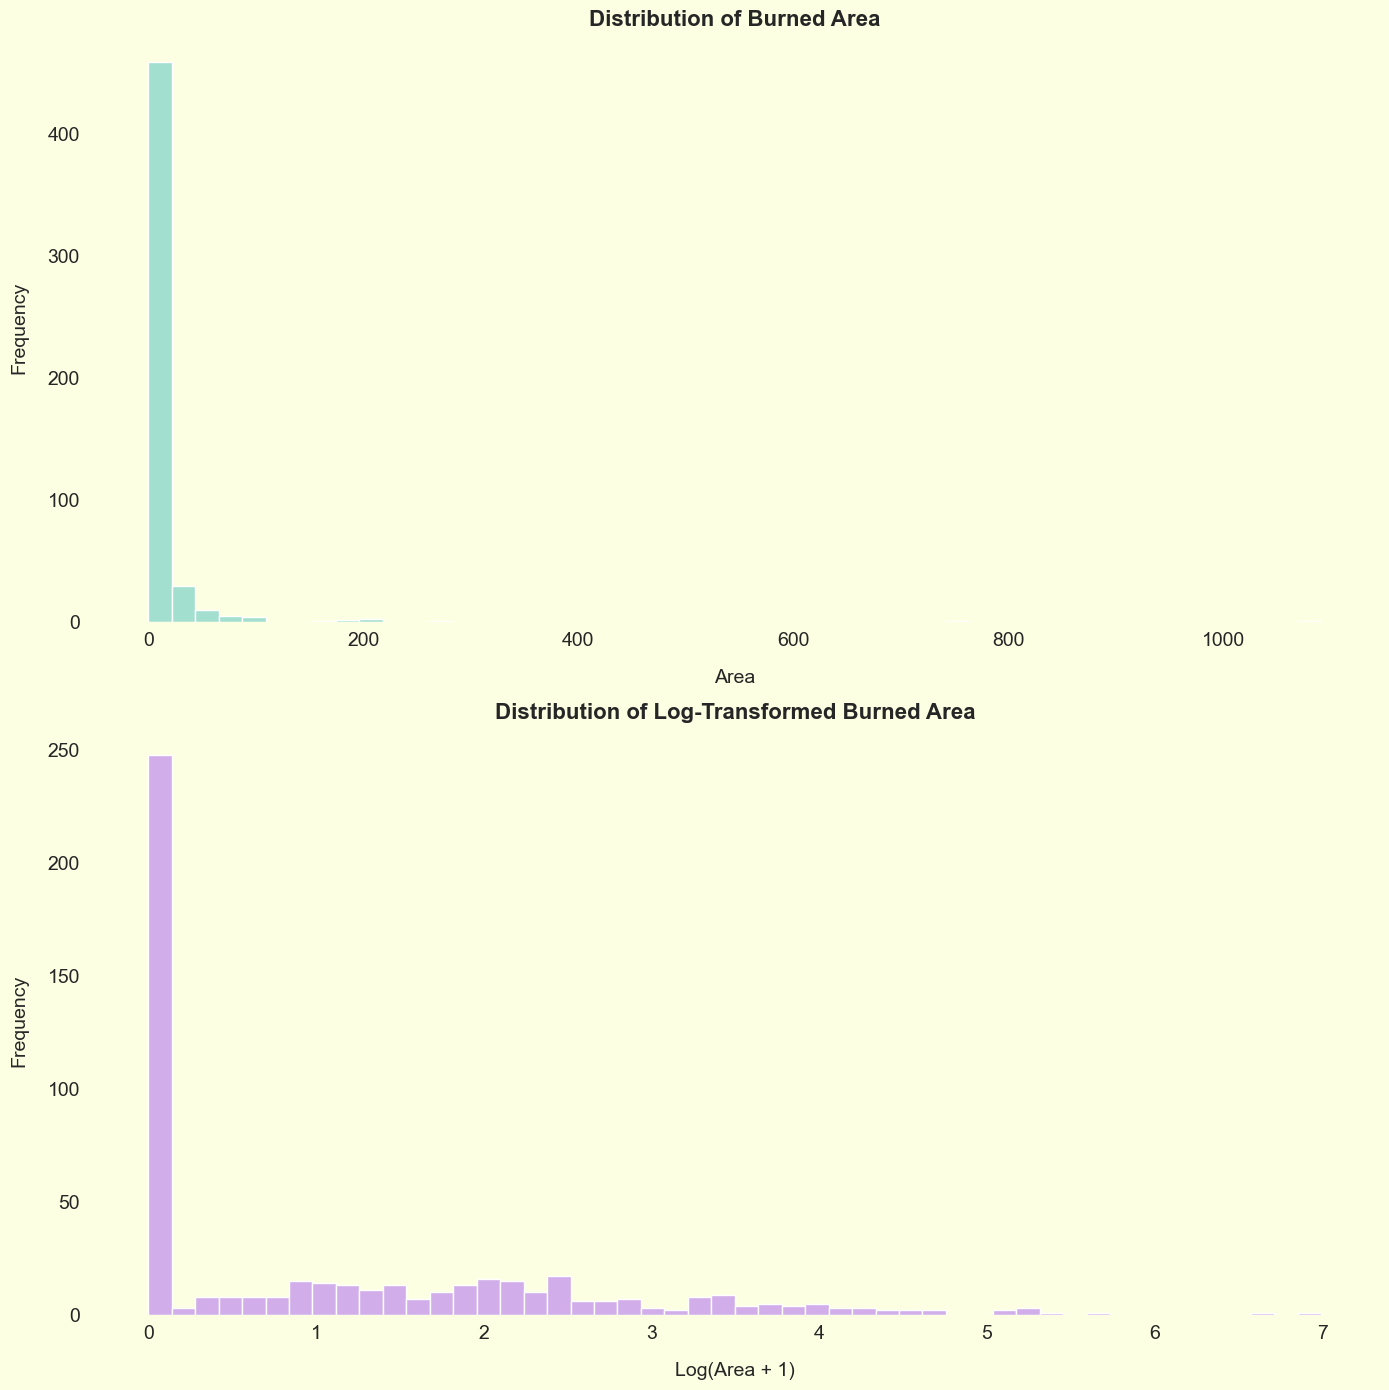

In [3]:
# Create figure and axes
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Histogram for raw 'area'
sns.histplot(fires_df['area'], bins=50, kde=False, color="#85d5c8", ax=axes[0])
axes[0].set_title("Distribution of Burned Area")
axes[0].set_xlabel("Area")
axes[0].set_ylabel("Frequency")

# Histogram for log-transformed 'area'
sns.histplot(fires_df['log_area'], bins=50, kde=False, color="#c392ec", ax=axes[1])
axes[1].set_title("Distribution of Log-Transformed Burned Area")
axes[1].set_xlabel("Log(Area + 1)")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

### Distribution Analysis of the Target Variable

---

I examined the distribution of the target variable `area` and its log-transformed version `log_area` using frequency bins and histograms.

**Original `area` distribution:**

- The distribution is extremely right-skewed.
- The majority of fires (≈95.7%) have very small burned areas within the first bin (0–54.5 hectares).
- Only a tiny fraction of observations fall in larger bins, with sporadic occurrences extending up to over 1,000 hectares.
- This highlights the presence of rare but extreme fire events in the dataset.

**Log-transformed `log_area` distribution:**

- The log transformation reduces skewness and spreads the values more evenly across bins.
- The first bin (≈0–0.35, corresponding roughly to area 0–0.42) still contains a large portion of fires (≈49%), but subsequent bins show a gradual and more interpretable decrease in frequency.
- The distribution after log transformation captures smaller, moderate, and larger fire events in a way that is easier to visualize and model.


## Categorical Distributions

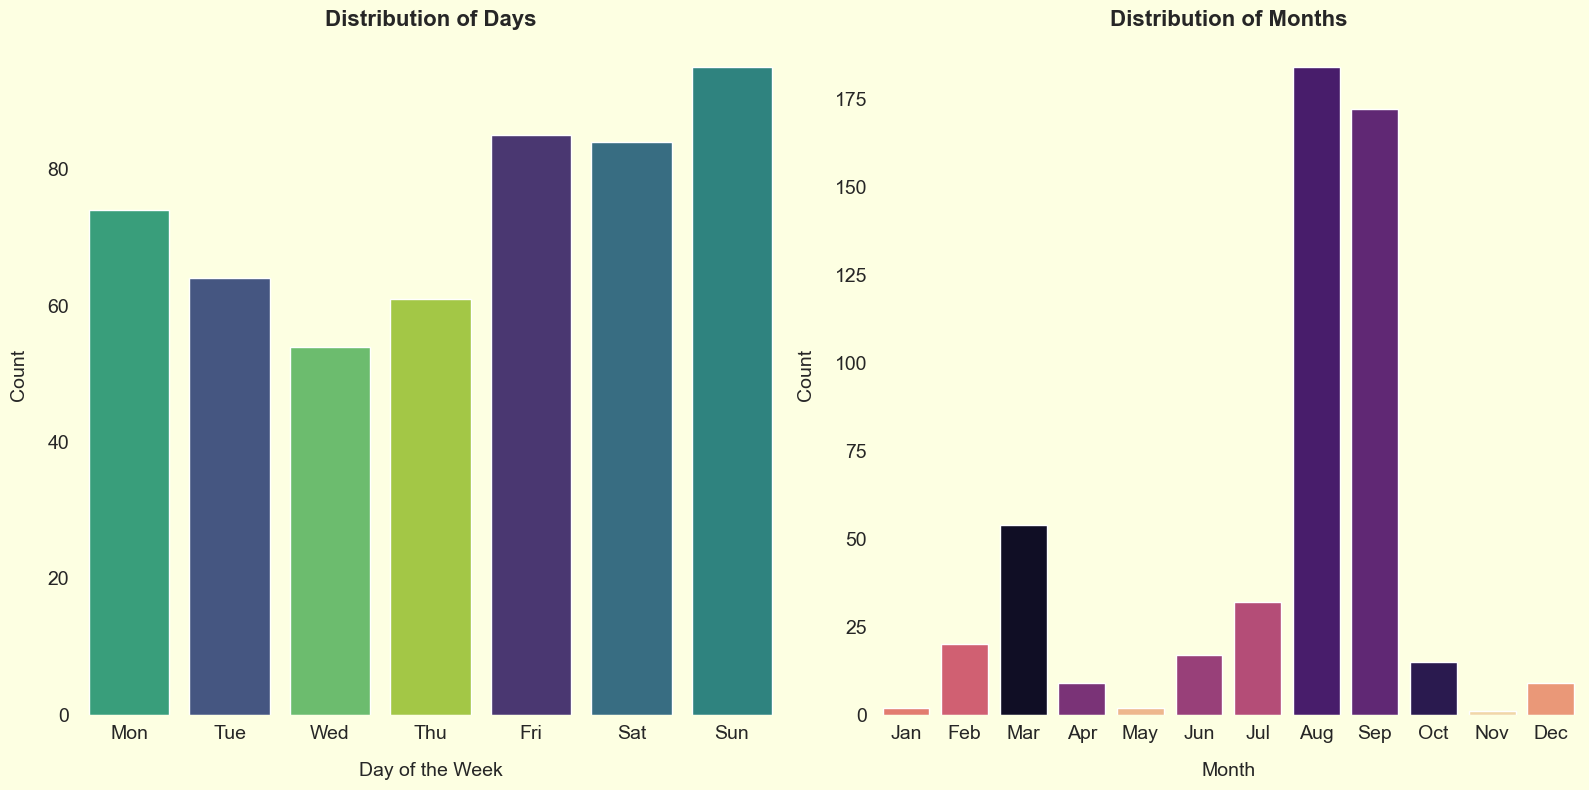

In [4]:
# Define the correct order for days and months (capitalized)
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Map lowercase values in the dataset to capitalized labels
fires_df["day"] = fires_df["day"].str.capitalize()
fires_df["month"] = fires_df["month"].str.capitalize()

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Barplot for 'day' in chronological order
sns.countplot(
    x="day", 
    data=fires_df, 
    ax=axes[0], 
    palette="viridis", 
    hue="day", 
    legend=False, 
    order=day_order
)
axes[0].set_title("Distribution of Days")
axes[0].set_xlabel("Day of the Week")
axes[0].set_ylabel("Count")

# Barplot for 'month' in chronological order
sns.countplot(
    x="month", 
    data=fires_df, 
    ax=axes[1], 
    palette="magma", 
    hue="month", 
    legend=False, 
    order=month_order
)
axes[1].set_title("Distribution of Months")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Categorical Columns: `day` and `month`

---

The dataset contains two categorical variables that describe the time dimension of the forest fire records: **day of the week** and **month of the year**.

#### Day of the Week
- The distribution of fire occurrences is **not fully uniform**.  
- The highest counts are on **Sunday (95)** and **Friday (85)**, followed closely by **Saturday (84)**.  
- The lowest counts are on **Wednesday (54)** and **Thursday (61)**.  
- While the differences are not extreme, there is a **slight concentration of fires toward weekends**, which may relate to weather patterns or human activity.

#### Month of the Year
- The monthly distribution shows a **strong seasonal pattern**.  
- Fires occur most frequently during **August (184)** and **September (172)**, followed by **March (54)** and **July (32)**.  
- Very few fires are recorded in **winter months**: **January (2)** and **December (9)**.  
- Spring months (**April: 9, May: 2**) and late autumn (**November: 1**) also show minimal activity.  
- This confirms that **summer and early autumn** are the peak fire seasons, strongly tied to climate conditions such as heat and dryness.


## Distribution of Log-Transformed Burned Area by Day and Month

In [5]:
# Summary statistics for Day vs Log(Areas)
day_summary = fires_df.groupby("day")["log_area"].describe()
day_summary = day_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
day_summary.rename(columns={"50%": "median"}, inplace=True)

# Summary statistics for Month vs Log(Areas)
month_summary = fires_df.groupby("month")["log_area"].describe()
month_summary = month_summary[["count", "mean", "50%", "std", "min", "25%", "75%", "max"]]
month_summary.rename(columns={"50%": "median"}, inplace=True)

print("Summary for 'day':")
display(day_summary)
print("\nSummary for 'month':")
display(month_summary)

Summary for 'day':


,count,mean,median,std,min,25%,75%,max
day,,,,,,,,
Fri,85.000,0.970,0.285,1.211,0.000,0.000,1.942,3.791
Mon,74.000,1.090,0.550,1.337,0.000,0.000,1.950,5.633
Sat,84.000,1.226,0.259,1.611,0.000,0.000,2.145,6.996
Sun,95.000,1.124,0.000,1.429,0.000,0.000,2.055,5.286
Thu,61.000,1.026,0.642,1.317,0.000,0.000,1.783,6.616
Tue,64.000,1.231,0.500,1.482,0.000,0.000,2.287,5.365
Wed,54.000,1.114,0.565,1.383,0.000,0.000,1.914,5.230



Summary for 'month':


,count,mean,median,std,min,25%,75%,max
month,,,,,,,,
Apr,9.000,1.089,0.000,1.486,0.000,0.000,1.725,4.129
Aug,184.000,1.045,0.435,1.361,0.000,0.000,1.796,6.616
Dec,9.000,2.572,2.462,0.449,1.853,2.329,2.937,3.249
Feb,20.000,1.088,0.371,1.292,0.000,0.000,2.014,3.966
Jan,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Jul,32.000,1.084,0.698,1.419,0.000,0.000,1.997,5.633
Jun,17.000,0.843,0.000,1.208,0.000,0.000,1.433,4.267
Mar,54.000,0.773,0.000,1.193,0.000,0.000,1.388,3.634
May,2.000,1.838,1.838,2.599,0.000,0.919,2.757,3.676


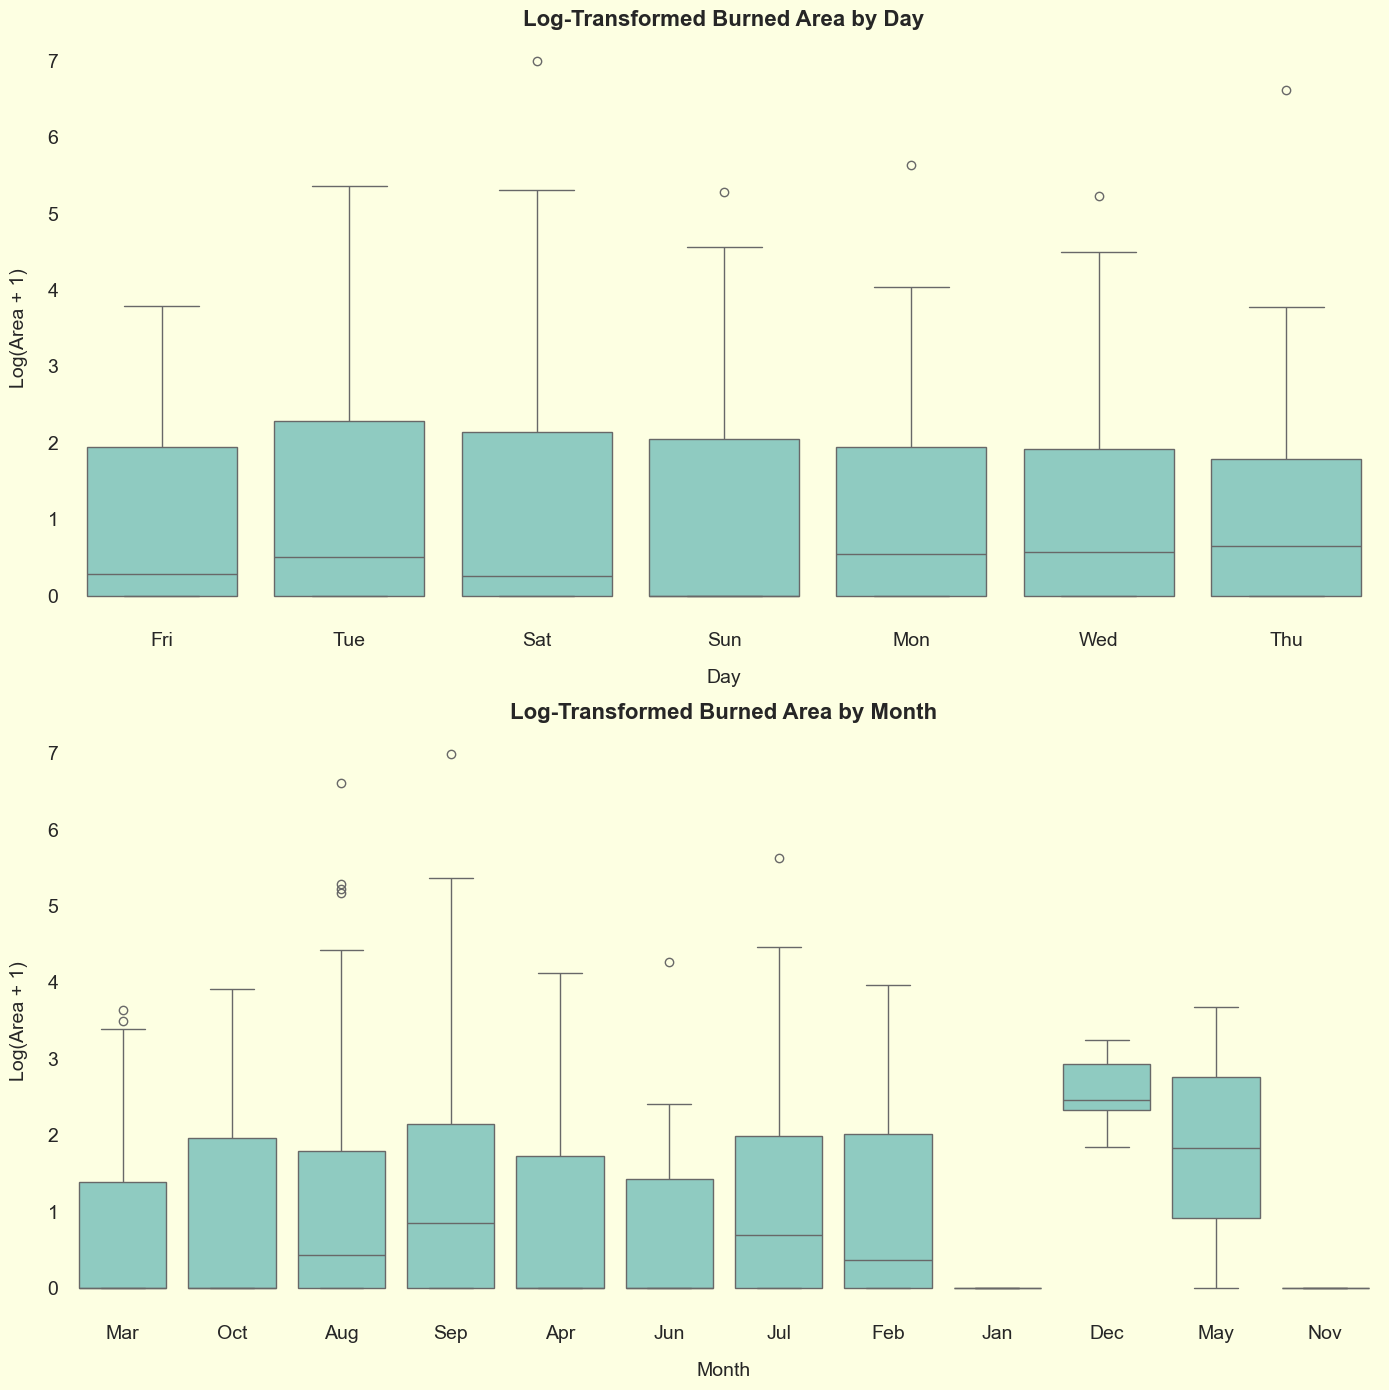

In [6]:
# Create a figure
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Boxplot: Day vs Log(Areas)
sns.boxplot(data=fires_df, x="day", y="log_area", ax=axes[0], color="#85d5c8")
axes[0].set_title("Log-Transformed Burned Area by Day")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Log(Area + 1)")

# Boxplot: Month vs Log(Areas)
sns.boxplot(data=fires_df, x="month", y="log_area", ax=axes[1], color="#85d5c8")
axes[1].set_title("Log-Transformed Burned Area by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Log(Area + 1)")

# Adjust layout
plt.tight_layout()
plt.show()

### Analysis of Log-Transformed Burned Area by Day and Month

---

#### Day of the Week
The summary statistics for `log_area` across different days of the week reveal some interesting patterns:

- **Median values** are low for most days, with Sunday having the lowest median (0.0), indicating that on many days no significant fire area is recorded.  
- **Mean values** are slightly higher than the medians, suggesting that some days experience a few extreme fire events. Tuesday (mean ≈ 1.23) and Saturday (mean ≈ 1.23) show the highest average log-transformed burned area.  
- **Variability** (std) is fairly consistent across days, ranging from ~1.21 to ~1.61. Saturday has the highest standard deviation, highlighting more inconsistent fire activity.  
- **Maximum values** indicate outliers on all days, with Saturday (≈6.996) and Monday (≈5.633) experiencing the largest single fire events.  

Overall, the distribution shows that fires are generally small on most days, but occasional extreme events skew the averages, particularly on weekends and early weekdays.

---

#### Month
The monthly summary provides insight into seasonal patterns:

- **High fire activity** is evident in August and September, with mean log_area values of 1.045 and 1.275, and median values well above 0, indicating more consistent fire events during late summer.  
- **Winter and early spring months** (Jan, Nov, Dec) show very low median burned areas, often 0, reflecting minimal fire occurrences. December is an exception with a small sample size but higher log_area (mean ≈ 2.57) due to a few extreme events.  
- **Variability** is largest in May and September, reflecting sporadic extreme fire events. May shows a particularly high standard deviation (~2.60) despite only two observations, indicating a single large fire significantly affecting the statistics.  
- **Outliers** are present in almost all months, particularly in summer and early fall, confirming that extreme fire events dominate the burned area distribution.  


## Numerical Distributions and Outliers

In [7]:
# List of numerical columns in your dataset
numerical_columns = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

# Create a dataframe with summary statistics
summary_df = fires_df[numerical_columns].describe().T

# Calculate IQR and outlier bounds
summary_df["IQR"] = summary_df["75%"] - summary_df["25%"]
summary_df["Lower Bound"] = summary_df["25%"] - 1.5 * summary_df["IQR"]
summary_df["Upper Bound"] = summary_df["75%"] + 1.5 * summary_df["IQR"]

# Display the summary statistics
display(summary_df)

,count,mean,std,min,25%,50%,75%,max,IQR,Lower Bound,Upper Bound
X,517.000,4.669,2.314,1.000,3.000,4.000,7.000,9.000,4.000,-3.000,13.000
Y,517.000,4.300,1.230,2.000,4.000,4.000,5.000,9.000,1.000,2.500,6.500
FFMC,469.000,90.580,5.698,18.700,90.200,91.600,92.800,96.200,2.600,86.300,96.700
DMC,496.000,111.195,64.008,1.100,70.800,108.300,141.575,291.300,70.775,-35.363,247.738
DC,474.000,550.673,246.061,7.900,441.200,664.500,713.900,860.600,272.700,32.150,1122.950
ISI,515.000,9.019,4.565,0.000,6.450,8.400,10.750,56.100,4.300,0.000,17.200
temp,496.000,18.885,5.748,2.200,15.475,19.300,22.725,33.300,7.250,4.600,33.600
RH,487.000,44.382,16.180,15.000,33.000,42.000,53.500,100.000,20.500,2.250,84.250
wind,482.000,4.022,1.794,0.400,2.700,4.000,4.900,9.400,2.200,-0.600,8.200
rain,485.000,0.023,0.306,0.000,0.000,0.000,0.000,6.400,0.000,0.000,0.000


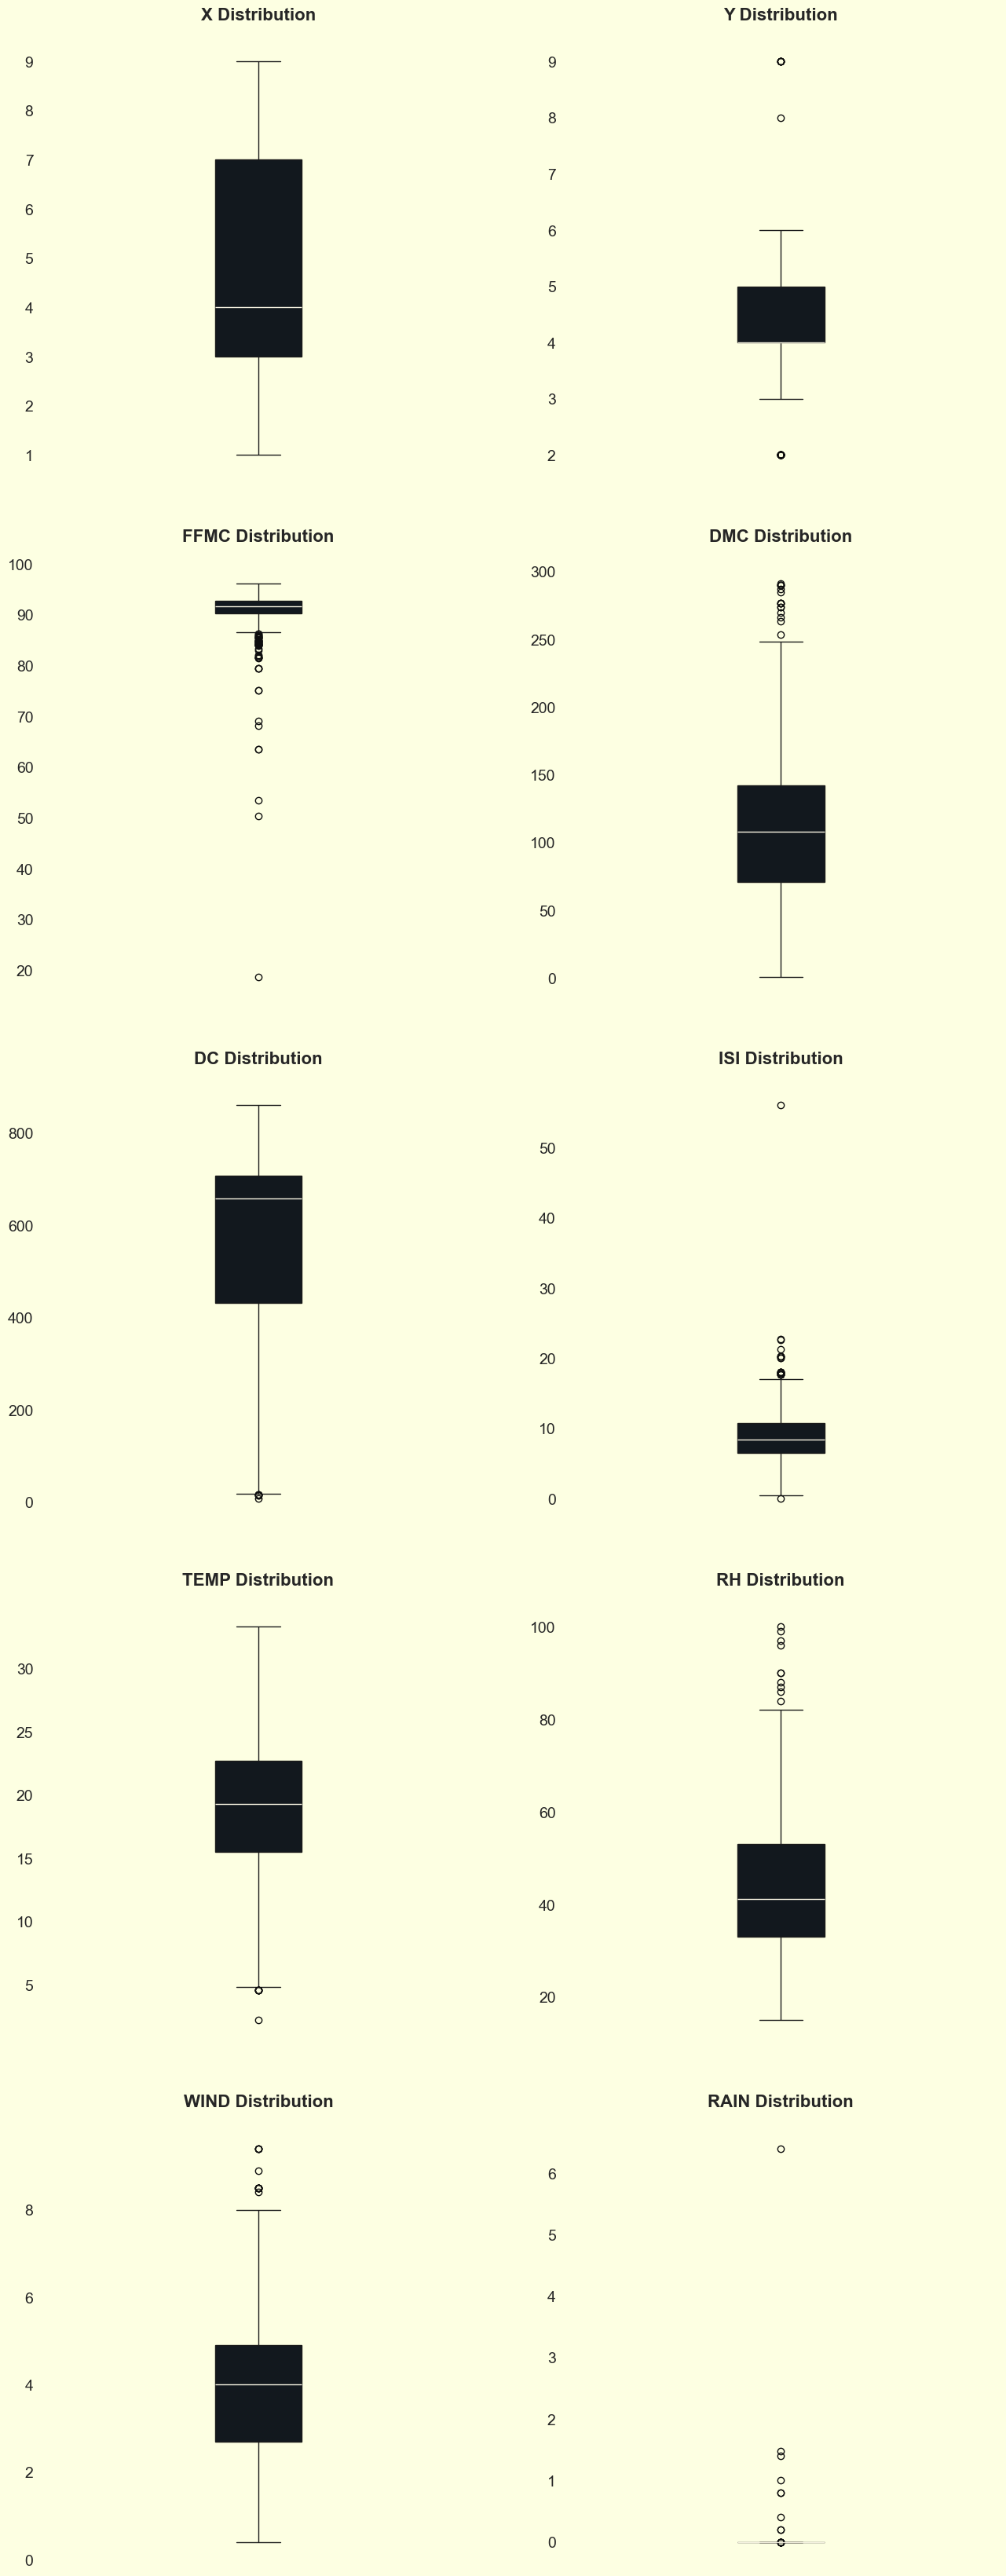

In [12]:
# Set up the subplots (5 rows × 2 columns)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 34))
axes = axes.flatten()  # Flatten for easy iteration

# Plot each numerical column
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.boxplot(
        data=fires_df, y=col, ax=ax, color='#101820', width=.2,
        boxprops=dict(edgecolor="#1a1a1a"),
        medianprops=dict(color="#F8F4E3"),
        whiskerprops=dict(color="#1a1a1a"),
        capprops=dict(color="#1a1a1a")
    )
    ax.set_title(f"{col.upper()} Distribution", pad=20)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout(pad=5)
plt.show()

## Missing Values

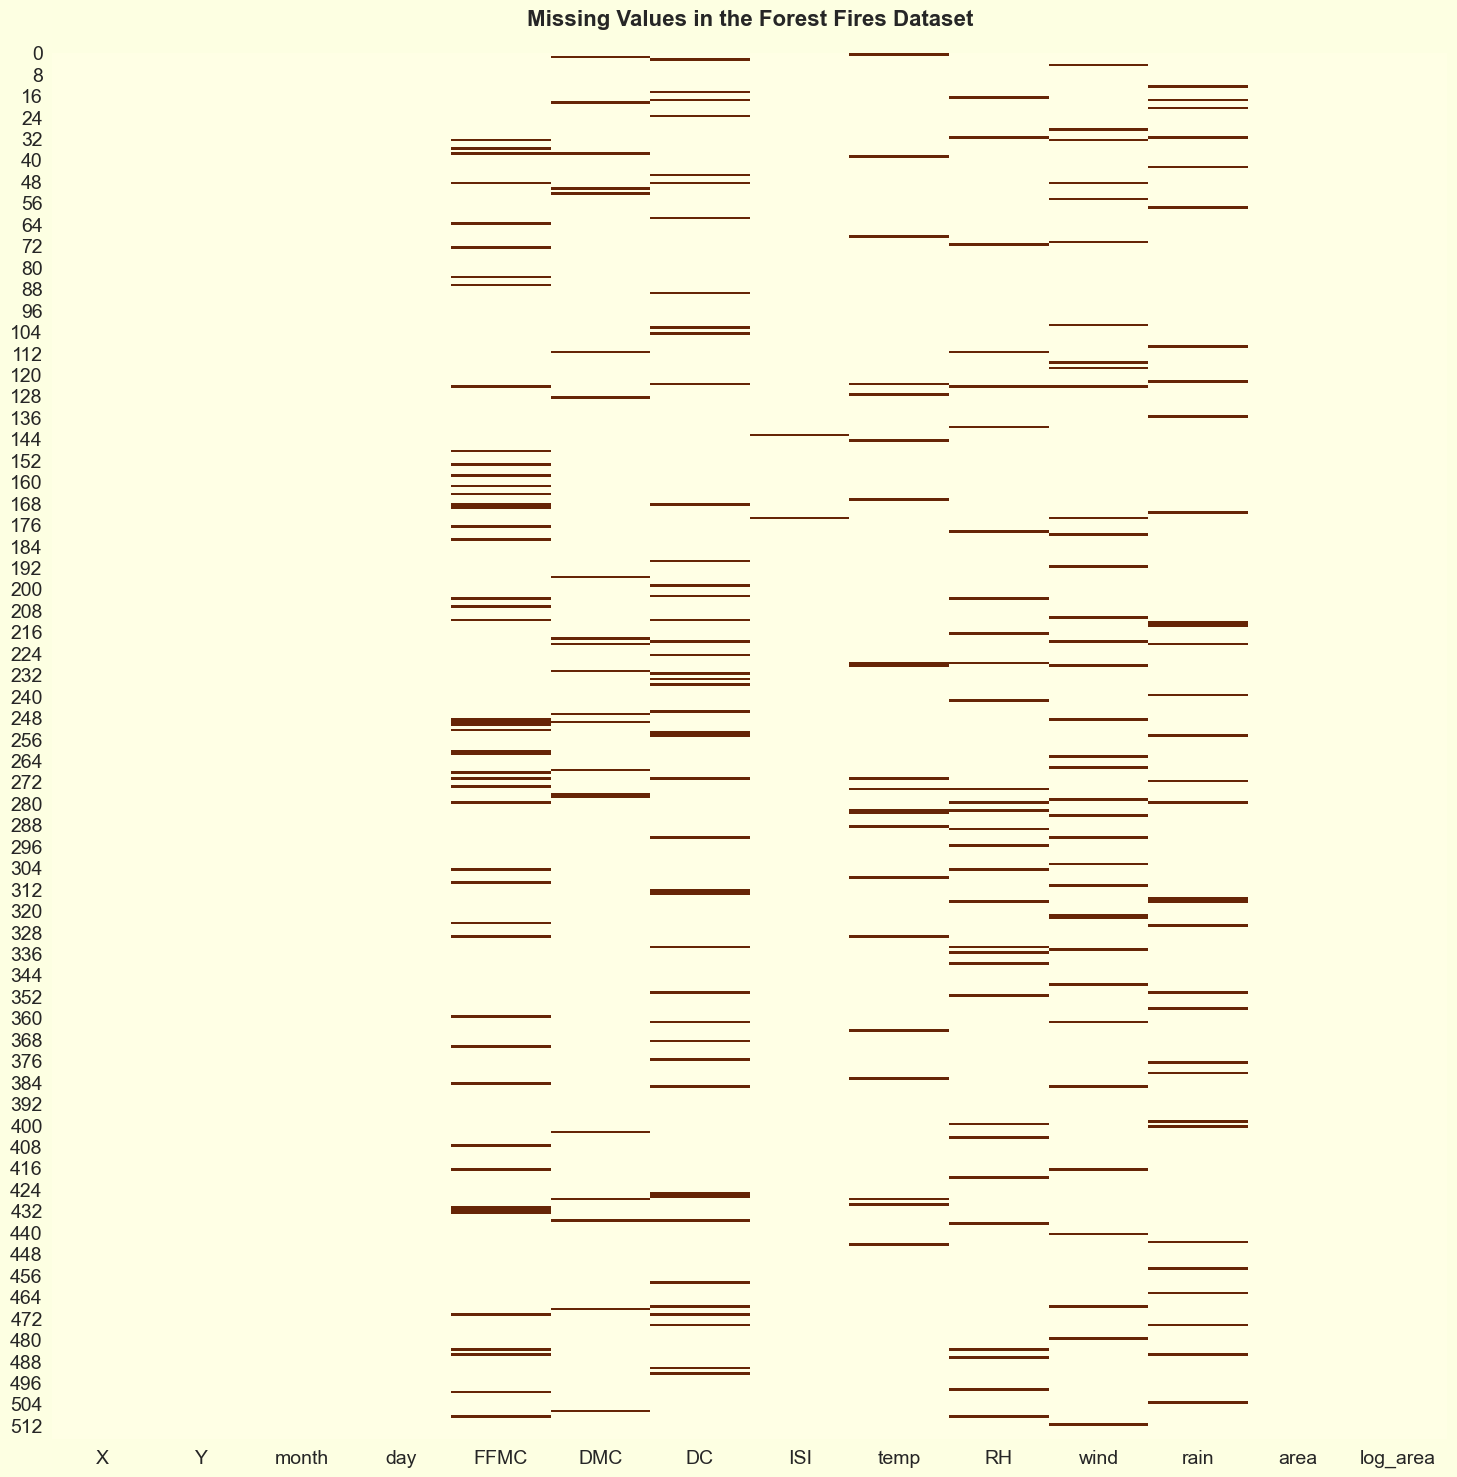

In [8]:
# Visualize missing values with a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(fires_df.isnull(), cbar=False, cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title("Missing Values in the Forest Fires Dataset", pad=20)
plt.show()

### Missing Values Exploration

---

I examined the dataset for **missing values**.  
I plotted a Seaborn heatmap of `isnull()` to scan for patterns. The missing cells are **sprinkled across rows and features** without clear blocks by time, location, or variable. In short, **no strong pattern**—the gaps look mostly random, which supports using an imputation method that leverages nearby samples.

---

### Imputation Plan: KNNImputer (numeric-only)

- I’ll impute **only numeric features** with **KNNImputer** so that estimates come from “similar” records.  
- Because KNN uses distances, I will **standardize numeric features before imputation** (so large-range variables like `DC` don’t dominate).  
- Categorical features (`month`, `day`) have no missing values and are left as-is.  
- The target `area` will not be imputed.


In [9]:
# Identify columns. Keep categoricals as-is. Impute numerics only (exclude target to be safe).
categorical_cols = ["month", "day"]
numeric_cols = [c for c in fires_df.columns if c not in categorical_cols + ["area"]]

# Standardize numeric features (so KNN distances are meaningful)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(fires_df[numeric_cols])

# KNN imputation on the scaled numeric matrix
imputer = KNNImputer(n_neighbors=5, weights="distance")
X_num_imputed_scaled = imputer.fit_transform(X_num_scaled)

# Inverse-scale back to original units and write into the dataframe
fires_df[numeric_cols] = scaler.inverse_transform(X_num_imputed_scaled)

# Sanity check: no NaNs should remain in numeric features
print("Missing values in the dataset after imputation:")
print("="*47)
print(fires_df.isnull().sum())

Missing values in the dataset after imputation:
X           0
Y           0
month       0
day         0
FFMC        0
DMC         0
DC          0
ISI         0
temp        0
RH          0
wind        0
rain        0
area        0
log_area    0
dtype: int64


### Handling Missing Values with KNN Imputation  

---

After identifying the missing values in the dataset, I applied **K-Nearest Neighbors (KNN) imputation** to handle them. This method replaces each missing value with a weighted average of the values from its nearest neighbors, where the neighbors are determined based on feature similarity.  

#### Why KNN Imputation?  
- **Preserves relationships between features**: Unlike mean or median imputation, which ignores dependencies between variables, KNN uses patterns in the data to estimate realistic values.  
- **Scales well with continuous data**: Since most of the missing values are in numeric features (e.g., weather conditions), KNN can effectively capture their natural correlations.  
- **Better estimates in small datasets**: The forest fire dataset is not very large, so leveraging feature similarity provides more reliable imputations than global averages.  

#### Implementation Steps  
1. **Standardization**: All numeric features were standardized using `StandardScaler`. This ensures that features with larger ranges (e.g., "DC") do not dominate distance calculations.  
2. **Imputation**: I used `KNNImputer` with 5 neighbors and distance-based weighting, meaning closer neighbors have a stronger influence on the imputed values.  
3. **Inverse transformation**: After imputation, the data was transformed back to its original scale to preserve interpretability.  

#### Result  
All missing values were successfully imputed, leaving a **complete dataset with no NaNs remaining**. This ensures that the dataset is now suitable for downstream analysis and modeling without introducing bias from dropped rows or unrealistic constant imputation.  


In [10]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X         517 non-null    float64
 1   Y         517 non-null    float64
 2   month     517 non-null    object 
 3   day       517 non-null    object 
 4   FFMC      517 non-null    float64
 5   DMC       517 non-null    float64
 6   DC        517 non-null    float64
 7   ISI       517 non-null    float64
 8   temp      517 non-null    float64
 9   RH        517 non-null    float64
 10  wind      517 non-null    float64
 11  rain      517 non-null    float64
 12  area      517 non-null    float64
 13  log_area  517 non-null    float64
dtypes: float64(12), object(2)
memory usage: 56.7+ KB
